**Universidad de los Andes**<br>
Facultad de Ingeniería<br>
__Maestría en Inteligencia Artificial__

# Clasificador de documentos en términos de objetivos de desarrollo sostenible (ODS)

Autores: __Andrés Vega__ y __David Méndez Acuña__

## Introducción

En este notebook, presentamos nuestra solución al segundo micro-proyecto del curso de machine learning no supervisado. El objetivo es clasificar automáticamente documentos en términos de una serie de los objetivos de desarrollo sostenible fijados por Naciones Unidas. Se espera facilitar el proceso de interpretación textual procedente de diferentes fuentes implicadas en la planeación participativa para el desarrollo a nivel territorial. La Figura 1 muestra la lista de objetivos de desarrollo sostenible que se usarán para la clasificación. 


<br>
<center>
    <img src="https://raw.githubusercontent.com/damenac/maia-uml/main/micro-proyectos/2_desarrollo_sostenible/ods.png" width="800">
</center>
<center>
Figura 1.Objetivos de desarrollo sostenible definidos por Naciones Unidas.
</center>
<br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import os

from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.manifold import TSNE
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')

def read_file(file_path=None):
    file = open(file_path, "r")
    content = file.read()
    file.close()
    return content


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/damenac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/damenac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Carga y preparación de datos

In [2]:
data_raw = pd.read_excel('./data/textos.xlsx')
data_raw

,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6
2,"Como resultado, un mayor y mejorado acceso al ...",13
3,Con el Congreso firmemente en control de la ju...,16
4,"Luego, dos secciones finales analizan las impl...",5
...,...,...
9651,Esto implica que el tiempo de las mujeres en e...,5
9652,"Sin embargo, estas fallas del mercado implican...",3
9653,El hecho de hacerlo y cómo hacerlo dependerá e...,9
9654,"Esto se destacó en el primer estudio de caso, ...",6


In [3]:
data_raw.describe()

,ODS
count,9656.000000
mean,7.993993
std,4.692995
min,1.000000
25%,4.000000
50%,7.000000
75%,12.000000
max,16.000000


In [4]:
data_raw.duplicated().sum()

0

In [5]:
data_raw.isna().sum()

textos    0
ODS       0
dtype: int64

In [6]:
x_train = data_raw["textos"]
y_train = data_raw["ODS"]

ods_labels = pd.DataFrame(data=['Fin de la probreza', 'Hambre cero', 'Salud y bienestar', 'Educación de calidad', 'Igualdad de género', 'Agua limpia y saneamiento',
                         'Energía asequible y no contaminante', 'Trabajo decente y desarrollo económico', 'Industria, innovación e infraestructura', 'Reducción de las desigualdades',
                         'Ciudades y comunidades sostenibles', 'Producción y consumo responsable','Acción por el clima', 'Vida submarina', 'Vida de ecosistemas terrestres', 
                         'Paz, justicia e instituciones sólidas', 'Alianzas para lograr los objetivos'], columns=["label"])

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, train_size=0.8)

## Procesamiento de texto

En esta sección, se hace el procesamiento de texto necesario para transformar los documentos en bolsas de palabras. 

In [7]:
from nltk.tokenize import word_tokenize
tokenized = x_train.apply(lambda x: word_tokenize(x))
tokenized

9620    [Esto, puede, lograrse, a, través, de, una, se...
4929    [Los, factores, sociales, y, culturales, son, ...
2302    [Los, centros, de, AEPI, de, calidad, responde...
8184    [Por, ejemplo, ,, en, Australia, ,, se, dispus...
5748    [Es, importante, destacar, que, el, uso, compa...
                              ...                        
5734    [No, más, del, 40, %, de, los, fondos, de, SP,...
5191    [Por, ejemplo, ,, con, el, umbral, de, pobreza...
5390    [Esto, convierte, al, turismo, en, una, indust...
860     [A, través, de, este, proceso, ,, se, crearon,...
7270    [Además, ,, la, red, de, distribución, no, se,...
Name: textos, Length: 7724, dtype: object

In [8]:
from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
tokenized_no_punct = x_train.apply(lambda x: tokenizer.tokenize(x))
tokenized_no_punct

9620    [Esto, puede, lograrse, a, través, de, una, se...
4929    [Los, factores, sociales, y, culturales, son, ...
2302    [Los, centros, de, AEPI, de, calidad, responde...
8184    [Por, ejemplo, en, Australia, se, dispuso, de,...
5748    [Es, importante, destacar, que, el, uso, compa...
                              ...                        
5734    [No, más, del, 40, de, los, fondos, de, SP, pu...
5191    [Por, ejemplo, con, el, umbral, de, pobreza, d...
5390    [Esto, convierte, al, turismo, en, una, indust...
860     [A, través, de, este, proceso, se, crearon, do...
7270    [Además, la, red, de, distribución, no, se, ma...
Name: textos, Length: 7724, dtype: object

In [9]:
nltk_stopwords = stopwords.words("spanish")
no_stopwords = tokenized_no_punct.apply(lambda x: [token for token in x if token not in nltk_stopwords])
no_stopwords

9620    [Esto, puede, lograrse, través, serie, medidas...
4929    [Los, factores, sociales, culturales, barrera,...
2302    [Los, centros, AEPI, calidad, responden, natur...
8184    [Por, ejemplo, Australia, dispuso, financiació...
5748    [Es, importante, destacar, uso, compartido, bi...
                              ...                        
5734    [No, 40, fondos, SP, pueden, destinarse, recur...
5191    [Por, ejemplo, umbral, pobreza, definido, 60, ...
5390    [Esto, convierte, turismo, industria, intensiv...
860     [A, través, proceso, crearon, dos, grupos, 1, ...
7270    [Además, red, distribución, mantiene, Alrededo...
Name: textos, Length: 7724, dtype: object

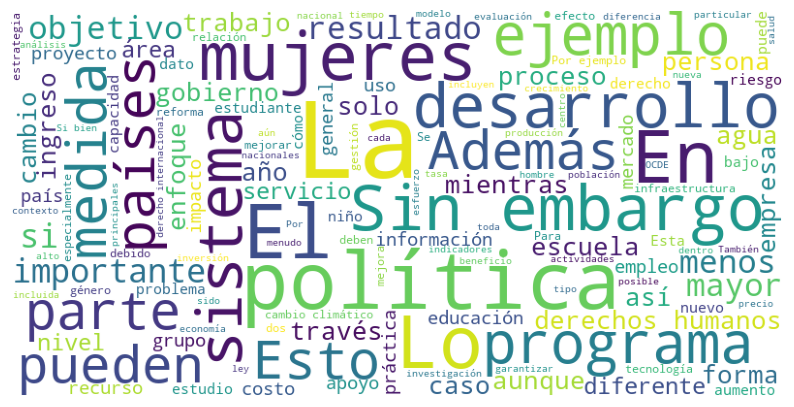

In [10]:
wc_text = ' '.join(word for text in no_stopwords for word in text)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color ='white',
    min_font_size=10,
    max_font_size=110
).generate(wc_text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [11]:
stemmer = PorterStemmer()
stemmed = no_stopwords.apply(lambda x: [stemmer.stem(token) for token in x])
stemmed

9620    [esto, pued, logrars, travé, seri, medida, mej...
4929    [lo, factor, social, cultural, barrera, import...
2302    [lo, centro, aepi, calidad, responden, natural...
8184    [por, ejemplo, australia, dispuso, financiació...
5748    [es, important, destacar, uso, compartido, bic...
                              ...                        
5734    [no, 40, fondo, sp, pueden, destinars, recurso...
5191    [por, ejemplo, umbral, pobreza, definido, 60, ...
5390    [esto, conviert, turismo, industria, intensiva...
860     [a, travé, proceso, crearon, do, grupo, 1, gru...
7270    [ademá, red, distribución, mantien, alrededor,...
Name: textos, Length: 7724, dtype: object

In [12]:
processed = stemmed.apply(lambda x: ' '.join(x))
processed

9620    esto pued logrars travé seri medida mejora pre...
4929    lo factor social cultural barrera important ac...
2302    lo centro aepi calidad responden naturaleza di...
8184    por ejemplo australia dispuso financiación sep...
5748    es important destacar uso compartido bicicleta...
                              ...                        
5734    no 40 fondo sp pueden destinars recurso humano...
5191    por ejemplo umbral pobreza definido 60 ingreso...
5390    esto conviert turismo industria intensiva coor...
860     a travé proceso crearon do grupo 1 grupo trata...
7270    ademá red distribución mantien alrededor 27 1 ...
Name: textos, Length: 7724, dtype: object

## Visualización de los datos en 2D usando t-SNE

In [13]:
tsvd = TruncatedSVD(n_components=100)

In [14]:
def visualize(data=None, dimred=None) :
    '''
    Este método permite visualizar los datos de entrada en un plano cartesiano de dos dimensiones
    a través del algoritmo de t-SNE. 
    '''
    data_dimred = dimred.fit_transform(data)

    tsne = TSNE(n_components=2, random_state=0, verbose=0, n_jobs=-1, learning_rate=10, perplexity=30, n_iter=3000, init='random', metric='cosine')
    data_tsne = tsne.fit_transform(data_dimred)

    N = 7724
    np.random.seed(42)
    random = np.random.permutation(data_raw.shape[0])

    consolidated_data = data_raw.loc[random[:N],:].copy()
    consolidated_data['ODS_labels'] = [ ods_labels.values[consolidated_data.iloc[i]['ODS']][0] for i in range(len(consolidated_data))]
    consolidated_data['tsne-x'] = data_tsne[:,0]
    consolidated_data['tsne-y'] = data_tsne[:,1]

    fig, ax = plt.subplots(figsize=(15, 7))
    scatter = ax.scatter(consolidated_data['tsne-x'], consolidated_data['tsne-y'],  c=consolidated_data['ODS'], cmap="tab20b")
    legend = ax.legend(*scatter.legend_elements(num=16), loc="upper left", title="ODS")
    ax.add_artist(legend)

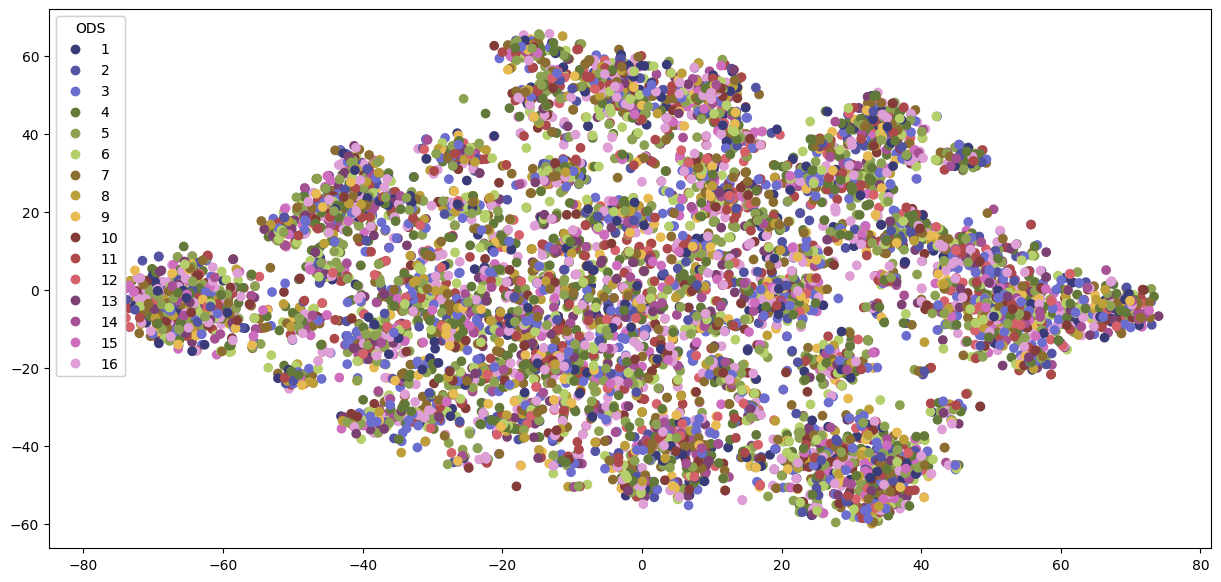

In [15]:
vectorizer_countVectorizer = CountVectorizer()
data_countVectorizer = vectorizer_countVectorizer.fit_transform(processed)
visualize(data=data_countVectorizer, dimred=tsvd)


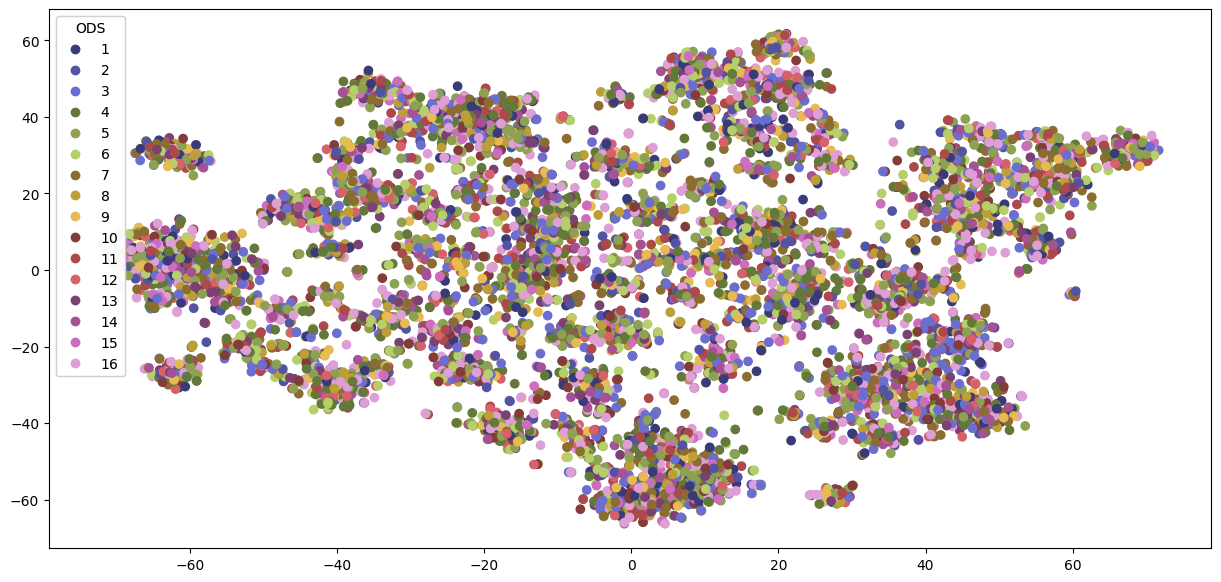

In [16]:
vectorizer_tfidVectorizer = TfidfVectorizer()
data_tfidVectorizer = vectorizer_tfidVectorizer.fit_transform(processed)
visualize(data=data_tfidVectorizer, dimred=tsvd)

## Selección del modelo de clasificación y entrenamiento

Existen varios modelos que pueden ayudarnos con este problema de clasificación. Para seleccionar un modelo apropiado, usamos una metodología basada en dos pasos. Por un lado, comparamos el desempeño de varios modelos con los valores de hiper-parámetros por defecto y sobre dos tipos de representación en bolsa de palabras distintas. 

Los modelos que incluimos en la comparación son:

- RandomForest
- Support Vector Machine con kernel lineal
- Support Vector Machine con kernel Gaussiano
- Regresión logística
- Multi-layer Perceptron Classifier.

Para la representación de bolsa de palabras, incluimos dos métodos en la comparación: 

- CountVectorizer
- TfidfVectorizer

A partir de esta comparación inicial, seleccionamos el mejor modelo con la mejor representación de bolsa de palabras y procedemos a encontrar los mejor valores para los hiper-parámetros.

In [17]:
def train_and_evaluate(model=None, dimred=None, vectorizer=None) : 
    '''
    Este método se encarga de crear y ejecutar un pipeline de entrenamiento que a partir de la bolsa
    de palabras en el parámetro 'vectorizer' aplica el algoritmo de reducción de la dimensionalidad
    y entrena el modelo dado. Durante la ejecución de este método, se imprime el reporte de clasificación
    correspondiente. 
    '''
    steps = [
        ("vectorizer", vectorizer),
        ("dimred", dimred),
        ("model", model)
    ]

    pipeline = Pipeline(steps)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_val)
    print(classification_report(y_val, y_pred))
    return pipeline

In [18]:
print("\n — Vectorizer: CountVectorizer; Model: RandomForest.\n ")
pipeline = train_and_evaluate(model = RandomForestClassifier(), dimred=tsvd, vectorizer=vectorizer_countVectorizer)

print("\n — Vectorizer: CountVectorizer; Model: SVC.\n ")
pipeline = train_and_evaluate(model = SVC(kernel='rbf'), dimred=tsvd, vectorizer=vectorizer_countVectorizer)

print("\n — Vectorizer: CountVectorizer; Model: SVC.\n ")
pipeline = train_and_evaluate(model = SVC(kernel='linear'), dimred=tsvd, vectorizer=vectorizer_countVectorizer)

print("\n — Vectorizer: CountVectorizer; Model: LogisticRegression. \n ")
pipeline = train_and_evaluate(model = LogisticRegression(), dimred=tsvd, vectorizer=vectorizer_countVectorizer)

print("\n — Vectorizer: CountVectorizer; Model: MLPClassifier. Parámetros: {hidden_layer_sizes=(15),max_iter=400, random_state=42, solver='lbfgs'} \n ")
pipeline = train_and_evaluate(model = MLPClassifier(), dimred=tsvd, vectorizer=vectorizer_countVectorizer)

print("\n — Vectorizer: TfidfVectorizer; Model: RandomForest. Parámetros: {max_dept=500} \n ")
pipeline = train_and_evaluate(model = RandomForestClassifier(), dimred=tsvd, vectorizer=vectorizer_tfidVectorizer)

print("\n — Vectorizer: TfidfVectorizer; Model: SVC. Parámetros: {kernel=Gaussiano, C=0.9} \n ")
pipeline = train_and_evaluate(model = SVC(kernel='rbf'), dimred=tsvd, vectorizer=vectorizer_tfidVectorizer)

print("\n — Vectorizer: TfidfVectorizer; Model: SVC. Parámetros: {kernel=Lineal, C=0.1} \n ")
pipeline = train_and_evaluate(model = SVC(kernel='linear'), dimred=tsvd, vectorizer=vectorizer_tfidVectorizer)

print("\n — Vectorizer: TfidfVectorizer; Model: LogisticRegression. Parámetros: {max_iter=500} \n ")
pipeline = train_and_evaluate(model = LogisticRegression(), dimred=tsvd, vectorizer=vectorizer_tfidVectorizer)

print("\n — Vectorizer: TfidfVectorizer; Model: MLPClassifier. Parámetros: {hidden_layer_sizes=(15),max_iter=400, random_state=42, solver='lbfgs'} \n ")
pipeline = train_and_evaluate(model = MLPClassifier(), dimred=tsvd, vectorizer=vectorizer_tfidVectorizer)


 — Vectorizer: CountVectorizer; Model: RandomForest.
 
              precision    recall  f1-score   support

           1       0.77      0.70      0.73        90
           2       0.50      0.27      0.35        71
           3       0.62      0.76      0.68       178
           4       0.73      0.88      0.79       200
           5       0.73      0.81      0.77       232
           6       0.79      0.83      0.81       135
           7       0.64      0.77      0.70       164
           8       0.55      0.34      0.42        86
           9       0.39      0.25      0.31        55
          10       0.46      0.27      0.34        60
          11       0.53      0.48      0.50       143
          12       0.57      0.39      0.46        64
          13       0.69      0.58      0.63       102
          14       0.43      0.44      0.43        64
          15       0.82      0.38      0.52        81
          16       0.69      0.89      0.78       207

    accuracy            

## Validación: Predicción en nuevos textos

Finalmente, utilizaomos el mejor modelo (en este caso, una red neuronal que sigue una arquitectura conforme a "multi-layer perceptron") para clasificar documentos nuevos. 

In [21]:
import urllib3 # Requiere —> pip3 install urllib3
http = urllib3.PoolManager()

def download_content(file_name = None) -> str :
    '''
    Descarga el archivo de acuerdo con el nombre que entra en el parámetro. 
    La descarga se hace desde el repositorio asociado a este proyecto. 
    '''
    base_path = "https://raw.githubusercontent.com/damenac/maia-uml/main/micro-proyectos/2_desarrollo_sostenible/data/publicaciones/"
    url = base_path + file_name
    response = http.request('GET', url)
    return response.data


def predecir(file_name = None, texto = None) :
    '''
    Usa el pipeline de predicción entrenado anteriormente para clasificar el documento que entra por parámetro. 
    El documento puede recibirse en forma de texto (usando el parametro 'texto') o a partir de un nombre de archivo
    que será descargado desde el repositorio de GitHub asociado al presente proyecto. 
    '''
    if texto == None :
        texto = download_content(file_name) 

    serie_prueba = pd.Series(data=[texto])
    prediccion_prueba = pipeline.predict(serie_prueba)
    resultado = ods_labels.iloc[prediccion_prueba[0]-1,0]
    return resultado, prediccion_prueba[0]

#### Ejemplo sencillo
Empezamos con una prueba sencilla de un texto escrito por los autores de este notebook. 

In [22]:
texto = 'Garantizar acceso al agua potable a la población vulnerable en los barrios del sur de Bogotá'
predecir(texto = texto)

('Agua limpia y saneamiento', 6)

#### Publicaciones en el sitio de Naciones Unidas en Colombia

Ahora, procedemos a clasificar documentos completos tomados del sitio web de las Naciones Uniades en Colombia y los clasificamos con respecto al objetivo de desarollo sostenible con el que se relacionan. 

Publicación sobre la lucha contra el VIH/SIDA y la relación entre la disriminación contra personas LBGT y su vulnerabilidad frente a las enfermedades de transmisión sexual. 

**Fuente:** https://colombia.un.org/es/262073-día-de-la-cero-discriminación-para-proteger-la-salud-de-todas-las-personas-hay-que-proteger 

In [23]:
predecir(file_name='publicacion_1.txt')

('Igualdad de género', 5)

Publicación sobre la visita de campo de la reina de los Paises Bajos al Valle de Aburrá (cerca de Medellín). Se trata de una visita de observación que muestra como dos empresas colombianas están trabajando en usar tecnología para facilitar el desarollo agrícola de la región. 

**Fuente:** https://colombia.un.org/es/261802-tecnología-y-finanzas-para-fomentar-un-futuro-más-verde 

In [24]:
predecir(file_name='publicacion_2.txt')

('Hambre cero', 2)

Publicación sobre la tercera visita del Consejo de Seguridad de la ONU a Colombia como parte de su seguimiento a los acuerdos de paz. 

**Fuente:** https://colombia.un.org/es/261491-colombia-la-paz-una-causa-social-real-que-entraña-un-esfuerzo-de-parte-de-toda-la-sociedad

In [25]:
predecir(file_name='publicacion_3.txt')

('Paz, justicia e instituciones sólidas', 16)

## Clasificación de las publicaciones de Naciones Unidas Colombia durante los años 2023 y 2024

Otra manera interesante de explotar el modelo construido en este documento, es analizar los documentos de una cierta fuente e identificar los objetivos de desarrollo sostenible más representados. En este caso, decidimos recopilar los documentos en la categoría de "Historias" del sitio webn de las Naciones Unidas en Colombia durante los años 2023 y 2024, para analizarlas con el clasificador. Es importante mencionar que seleccionamos la sección de "Historias" porque es precisamente esta sección la que se encarga de compilar los esfuerzos de Naciones Unidas para que el país logre sus objetivos desarrollo sostenible. 

**Fuente:** https://colombia.un.org/es/stories

__Nota:__ Las publicaciones han sido organizadas en archivos de texto y publicadas en un repositorio en GitHub. El código a continuación, se encarga de descargar los archivos correspondientes, ejecutar la inferencia sobre el modelo de clasificación y consolidar los resultados en un diagrama de barras.

In [26]:
publications_count = np.zeros(len(ods_labels))

for i in range(1, 38):
    label, index = predecir(file_name="publicacion_" + str(i) + ".txt")
    publications_count[index - 1] = publications_count[index - 1] + 1

ods_labels["publications"] = publications_count
ods_labels

,label,publications
0,Fin de la probreza,0.0
1,Hambre cero,3.0
2,Salud y bienestar,3.0
3,Educación de calidad,2.0
4,Igualdad de género,13.0
5,Agua limpia y saneamiento,1.0
6,Energía asequible y no contaminante,0.0
7,Trabajo decente y desarrollo económico,2.0
8,"Industria, innovación e infraestructura",2.0
9,Reducción de las desigualdades,0.0


Text(0.5, 1.0, 'Cantidad de publicaciones')

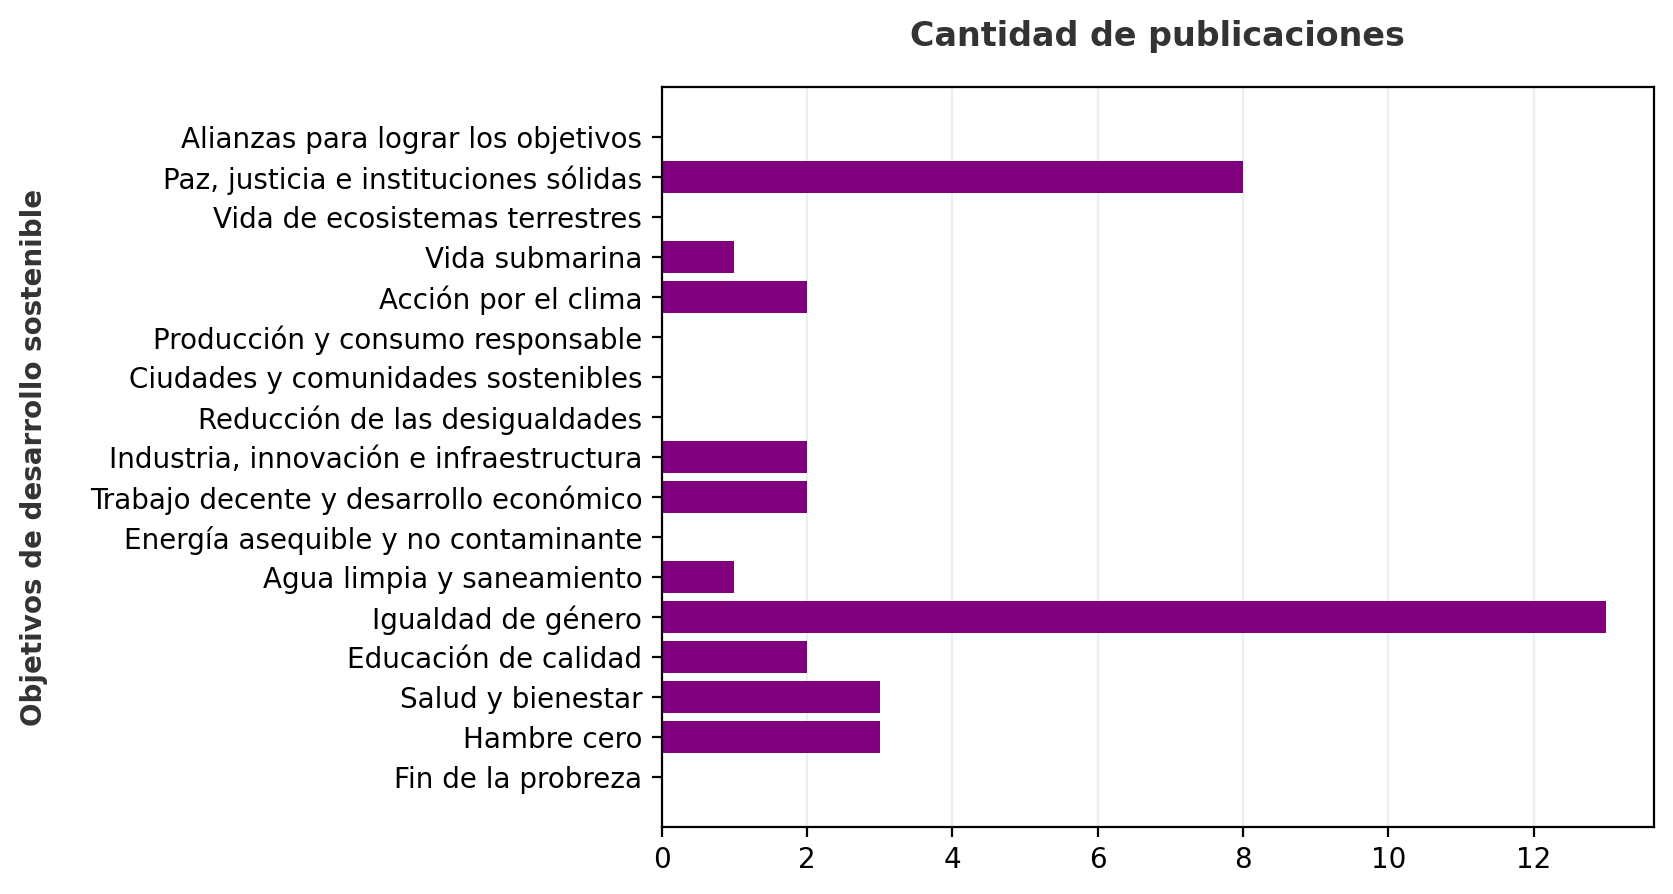

In [ ]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

fig, ax = plt.subplots()
plt.barh(
    y=ods_labels['label'],
    width=ods_labels['publications'], 
    color='purple'
)
ax.set_axisbelow(True)
ax.xaxis.grid(True, color='#EEEEEE')
ax.yaxis.grid(False)
ax.set_ylabel('Objetivos de desarrollo sostenible', labelpad=15, color='#333333', weight='bold')
ax.set_title('Cantidad de publicaciones', pad=15, color='#333333', weight='bold')